# 커스텀 데이터로 yolov2-tiny 모델 학습하기
darknet 사용

---



## **1. 학습할 이미지들을 준비**

- 학습할 이미지와 라벨링정보가 들어있는 텍스트파일을 준비
- 라벨링할때 필자는 https://roboflow.com/ 사이트 이용하여  yolo darknet 형식으로 export하였다.
- 폴더이름을 images로 하나 만들어서 이미지와 텍스트파일을 전부 넣고 압축시켜서 구글 드라이브에 올려둔다.




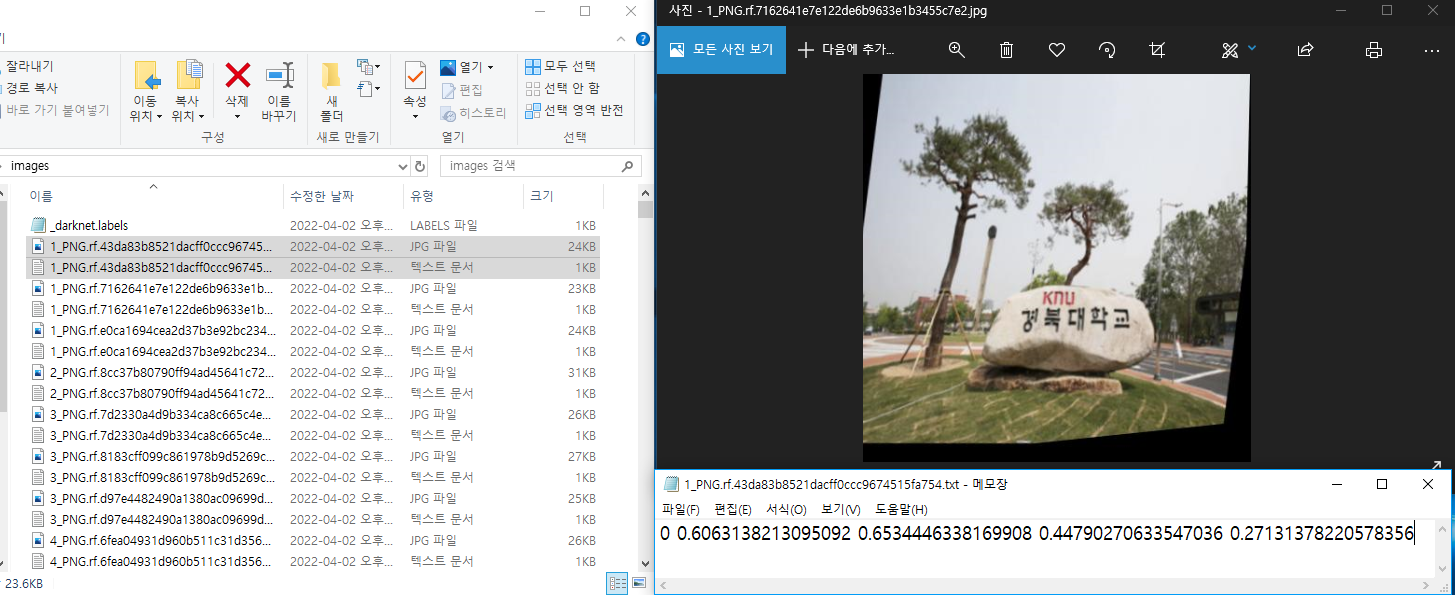

구글드라이브에 올린 압축 파일을 코랩에 다운로드하는 방법은 해당 블로그 참조

https://lapina.tistory.com/140

In [ ]:
# 압축파일 코랩에 다운로드
!gdown https://drive.google.com/uc?id=1mXg_Uuah1Y2REemNaeI47jgAHMAOCQZE

Downloading...
From: https://drive.google.com/uc?id=1mXg_Uuah1Y2REemNaeI47jgAHMAOCQZE
To: /content/images.zip
100% 7.52M/7.52M [00:00<00:00, 57.7MB/s]


## 2.darknet 설치
----------

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15412, done.
remote: Total 15412 (delta 0), reused 0 (delta 0), pack-reused 15412
Receiving objects: 100% (15412/15412), 14.02 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (10356/10356), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

##3.학습에 필요한 파일들 세팅하기
------------

###3-1. darknet/cfg/ 폴더 안에서 yolov2-tiny.cfg 파일 더블클릭하여 '직접' 수정해주기
yolov2-tiny.cfg 파일 안에는 해당 모델의 레이어 정보 및 학습할 때 필요한 파라미터들에 대한 정보가 들어있다.

해당 모델은 탐지할 class 개수가 80개로 설정되어 있어 수정해주어야한다.

**<본인 모델이 n개 클래스 탐지하는 모델일 경우>**

- 3번째 줄 batch = 64  로 수정

- 4번째 줄 subdivisions = 8 로 수정

- 125번째 줄 classes = n 으로 수정

- 119번째 줄 fliters = ( 5 + n ) * 5 값으로 수정

- 20번째 줄 max_batches = 6250 * n + 200 으로 수정

- 21번째 줄 steps = (6250 * n + 200) * 8 / 10, (6250 * n + 200) * 9 / 10



###3-2. weights 값 다운받기

In [ ]:
# Download weights darknet model 53
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-04-02 10:53:58--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  23.1MB/s    in 7.5s    

2022-04-02 10:54:06 (20.6 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



### 3-3.이미지 다운받기
이미지 data/obj폴더로 압축 해제

In [ ]:
!mkdir data/obj
!unzip /content/images.zip -d data/obj 

mkdir: cannot create directory ‘data/obj’: File exists
Archive:  /content/images.zip
 extracting: data/obj/images/_darknet.labels  
  inflating: data/obj/images/1_PNG.rf.43da83b8521dacff0ccc9674515fa754.jpg  
  inflating: data/obj/images/1_PNG.rf.43da83b8521dacff0ccc9674515fa754.txt  
  inflating: data/obj/images/1_PNG.rf.7162641e7e122de6b9633e1b3455c7e2.jpg  
  inflating: data/obj/images/1_PNG.rf.7162641e7e122de6b9633e1b3455c7e2.txt  
  inflating: data/obj/images/1_PNG.rf.e0ca1694cea2d37b3e92bc234c8e1fee.jpg  
  inflating: data/obj/images/1_PNG.rf.e0ca1694cea2d37b3e92bc234c8e1fee.txt  
  inflating: data/obj/images/10_PNG.rf.32533d47de00b0fbb6e237db5116b6ea.jpg  
  inflating: data/obj/images/10_PNG.rf.32533d47de00b0fbb6e237db5116b6ea.txt  
  inflating: data/obj/images/10_PNG.rf.69e87f4c8ccde678817748196b8ba368.jpg  
  inflating: data/obj/images/10_PNG.rf.69e87f4c8ccde678817748196b8ba368.txt  
  inflating: data/obj/images/10_PNG.rf.a723b1515cbc38758e73c72ed30ea28b.jpg  
  inflating: dat

###3-4. 이미지들의 경로정보가 담긴 train.txt파일 생성
다운받은 이미지들의 경로를 모두 읽어 train.txt 파일에 적어준다.

In [ ]:
import glob
images_list = glob.glob("data/obj/images/*.jpg")
#images_list = glob.glob("data/obj/images/*.png")
print(images_list)

In [ ]:
#Create training.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

###3-5. darknet/data 폴더 안에 obj.names 파일 생성
- obj.names 안에는 탐지하려는 클래스명이 나열되어있다.

- 앞서 압축해제한 파일에 들어있던 라벨파일을 복사해온다.



In [ ]:
%cp data/obj/images/_darknet.labels /content/darknet/data/obj.names

- 만약 라벨파일이 없으면 직접 obj.names파일 만들어서 클래스 나열해주면 된다.

ex)

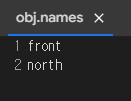

###3-6. darknet/data 폴더안에 obj.data 파일 생성
- 앞서 만든 파일들의 정보를 총집합한 파일이다.
- valid는 없어도 학습 때 알아서 train셋을 8:2로 나누어서 학습한다.

<파일 안에 들어가야 하는 내용>

classes = 클래스 갯수

train = train.txt 경로

valid = valid.txt 경로

names = obj.names 경로

backup = 학습 중간중간 결과를 백업할 경로



In [ ]:
#학습된 모델을 구글 드라이브에 백업하기 위해서 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#파일 쓰기 함수
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/darknet/data/obj.data
classes = 2
tarin = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = /content/drive/MyDrive

##4.학습
-----------
학습 실행 코드

!./darknet detector train .data경로 .cfg경로 weight경로


In [ ]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov2-tiny.cfg darknet53.conv.74 -dont_show

###설명

Region Avg IOU , Class 값이 1에 가까울수록 좋음

- 최소 4시간 이상 평균 8시간 정도의 상당한 시간이 소요됨 

- 중간중간 백업 폴더에 .weights 파일 생성됨

- 어느정도 성능나오면 학습 중단하고 .weights 파일 쓰면됨

- 코랩특성상 일정시간 방치해두면 팅김

- 20분마다 화면 클릭하면서 체크해줘야함

꿀팁)

- 개발자도구 열어서 콘솔창에 아래 코드 실행하면 튕김 방지



```
function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000 * 20)
```




